<h2>1.Wstęp</h2>

W XXI wieku piłka nożna jest zdecydowanie najpopularniejszym sportem na świecie, a niezliczona ilość lig w większości oficjalnie uznanych państw pozwala zaspokoić nawet gusta osób o najbardziej ekscentrycznych opodobaniach co do jakości rozgrywek. Aktualnie do najpopularniejszych oraz najlepszych, zgodnie z rankingiem FIFA, zaliczamy pięć lig:

* <b>Premier League</b> - najlepsza liga w Angli,

* <b>Primera Division</b> - najlepsza liga w Hiszpani,

* <b>Bundesliga</b> - najlepsza liga w Niemczech,

* <b>Serie A</b> - najlepsza liga we Włoszech,

* <b>Ligue 1</b> - najlepsza liga we Francji.

W związku z popularnością tej dyscypliny jest ona również świetnie opłacana. Gracze występujący w Angielskiej ekstraklasie zarabiają średnio , co jest najwyższym wynikiem wśród wymienionych rozgrywek ligowych. Niniejsze badanie pozwoli określić jakie są dominanty zarobków w poszczególnych ligach (Regresja wieloraka) oraz czy na podstawie statystyk zawodników jesteśmy w stanie określić ich ogólną pozycję na boisku (KNN, Random Forest, AdaBoosting). Ze względu na różnice w statystykach, którymi charakteryzują się piłkarze, w badaniu zostali wzięci pod uwagę wyłącznie zawodnicy z pola.

<h2>2.Dane</h2>

Dane w większości zostały pobrane ze strony https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset i dotyczą sezonu 2019/2020. Dotyczą one statystyk jakie posiadają piłkarze w najnowszej odsłonie kultowej serii jaką jest FIFA. W podstawowej formie nie nadawały się do przeprowadzenia na ich podstawie analizy, w związku z czym zostały poddane obróbce, która została zaprezentowana poniżej.

In [995]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
from IPython.core.display import HTML

In [1028]:
#Centering
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

<h3>2.1. Podstawowa forma danych</h3>

   Podstawowa forma danych została zaprezentowana w tabeli poniżej. Dane zawierają takie informację o piłkarzach jak imię i nazwisko,wiek, narodowość, klub w jakim grają czy też ich zarobki. Spoza danych zawierających oficjalne dane można wyróżnić ich ocenę ogólną,potencjał oraz liczne zmienne dotyczące umiejętności obrony, kontroli piłki, podań i strzałów.

In [959]:
path = "C:/Users/User/Desktop/players_20.csv"
sns.set(style='darkgrid')
data = pd.read_csv(path)
data.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


Dane posiadają 104 kolumny opisujące poszczególnych piłkarzy, jednak znaczna ich część jest bezużyteczna w badaniu, w związku z czym została usunięta ze zbioru. Do zmiennych usuniętych zaliczają się: sofifa id, link do profilu piłkarza, typ budowy ciała, czy zawodnik posiada "prawdziwą" twarz w grze, klauzula odejścia, pozycja w reprezentacji, tagi opisujące piłkarzy, skąd piłkarz jest wypożyczony, numer koszulki, kiedy gracz dołączył do zespołu, numer koszulki w reprezentacji, międzynarodowa reputacja, cechy szczególne piłkarzy oraz wszystkie zmienne dotyczące oceny ogólnej na pozycjach poza główną. Ponadto warto wspomnieć, że zmienne dotycząca zarobków odnosi się do miesięcznego wynagrodzenia w Euro.

<h3>2.2. Tworzenie zmiennych</h3>

W związku z tym jak bardzo jest to rozbudowany zbiór tworzenie nowych zmiennych ograniczyło się wyłącznie to utworzenia kolumn dotyczących liczby pozycji na jakich może występować gracz (od 1 do 3), głównej pozycji oraz na jej podstawie kolumny z pozycją przypisaną do jednej z 6 głównych kategorii. Jak już było wspomniane we wstępie bramkarze ze względu na inne statystyki ich charakteryzujące zostali wykluczeni z badania. Ponandto na bazie kolumny dotyczącej tego w jakim klubie występuje piłkarz zostali wybrani tylko gracze z 5 najsilniejszych lig w Europie oraz utworzona została kolumna opisująca w jakiej lidze występuje gracz.

In [960]:
#Remove useless columns and goalkeepers
data = data.iloc[:,:len(data.columns) - 26]
data = data.drop(columns = ["sofifa_id", "player_url", "body_type", "real_face", "release_clause_eur", "nation_position",
                     "player_tags","team_jersey_number", "loaned_from", "joined", "nation_jersey_number",
                    "player_traits","international_reputation"])
data = data[data.columns.drop(list(data.filter(regex= 'gk_')))]
data = data[data.columns.drop(list(data.filter(regex= 'goalkeeping_')))]
data = data.dropna(subset = ["team_position"])
data = data[~data.player_positions.isin(["GK"])]

#Select player only from the best leagues
premierLeague_teams = ["Liverpool", "Manchester City", "Leicester City","Chelsea","Manchester United","Wolverhampton Wanderers",
                       "Sheffield United","Tottenham Hotspur","Arsenal","Burnley","Crystal Palace","Everton",
                      "Newcastle United", "Southampton", "Brighton & Hove Albion","West Ham United", "Watford","Bournemouth",
                       "Aston Villa", "Norwich City"]
bundesliga_teams = ["FC Bayern München", "Borussia Dortmund", "Bayer 04 Leverkusen","RB Leipzig","Borussia Mönchengladbach","Eintracht Frankfurt",
                       "FC Schalke 04","SV Werder Bremen","TSG 1899 Hoffenheim","VfL Wolfsburg","Hertha BSC","1. FC Köln",
                      "FC Augsburg", "1. FSV Mainz 05", "SC Freiburg","Fortuna Düsseldorf", "1. FC Union Berlin","SC Paderborn 07"]

primeraDivision_teams = ["FC Barcelona", "Real Madrid", "Atlético Madrid","Valencia CF","Real Betis","Sevilla FC","Athletic Club de Bilbao",
                       "Real Sociedad","Villarreal CF","Getafe CF","Levante UD","RC Celta","RCD Espanyol","SD Eibar",
                         "Real Valladolid CF", "Deportivo Alavés","CD Leganés", "Granada CF","CA Osasuna","RCD Mallorca"]
serieA_teams = ["Juventus", "Inter", "Napoli","Lazio","Atalanta","Milan", "Roma", "Torino", "Fiorentina", "Brescia",
                       "Cagliari","Udinese","Genoa","Sampdoria","Parma","Sassuolo", "Bologna", "Hellas Verona", "SPAL", "Lecce"]
ligueOne_teams = ["Paris Saint-Germain", "Olympique Lyonnais", "AS Monaco","Olympique de Marseille","LOSC Lille","AS Saint-Étienne",
                       "Stade Rennais FC","FC Girondins de Bordeaux","Montpellier HSC","OGC Nice","FC Nantes","RC Strasbourg Alsace",
                      "Angers SCO", "Toulouse Football Club", "Amiens SC","Stade de Reims", "FC Metz","Stade Brestois 29",
                       "Dijon FCO", "Nîmes Olympique"]
data = data[data.club.isin(premierLeague_teams + bundesliga_teams + primeraDivision_teams + serieA_teams + leagueOne_teams)]

#Create colum with leagues
data["league"] = data[["club"]]
data[["league"]] = data.league.replace(premierLeague_teams, "Premier League")
data[["league"]] = data.league.replace(bundesliga_teams, "Bundesliga")
data[["league"]] = data.league.replace(primeraDivision_teams, "Primera Division")
data[["league"]] = data.league.replace(serieA_teams, "Serie A")
data[["league"]] = data.league.replace(leagueOne_teams, "Ligue 1")

Następnie na bazie kolumny dotyczącej pozycji na jakich gracz grywa często i z sukcesami zostały utworzone zmienne dotycząca liczby pozycji oraz głównej pozycji, a następnie na jej podstawie została utworzona kolumna z informacją, do której z sześciu ogólnych pozycji ona należy (Środkowy obrońca, boczny obrońca, środkowy pomocnik, boczny pomocnik, napastnik oraz skrzydłowy).

In [961]:
#Get main player position
data["main_position"] = data.player_positions.str.split(',').str[0]

#Create Column with 3 general positions(Defender, Midfielder, Striker)
data["general_position"] = data[["main_position"]]
data[["general_position"]] = data.general_position.replace(["CB"], "Central Defender")
data[["general_position"]] = data.general_position.replace(["LB", "RB", "RWB", "LWB"], "Side Defender")
data[["general_position"]] = data.general_position.replace(["CM", "CDM", "CAM"], "Central Midfielder")
data[["general_position"]] = data.general_position.replace(["LM", "RM"], "Side Midfielder")
data[["general_position"]] = data.general_position.replace(["LW", "RW"], "Winger")
data[["general_position"]] = data.general_position.replace(["ST", "CF"], "Striker")

#Create column with number of player position
data["number_of_positions"] = [len(part) for part in data.player_positions.str.split(",")]

In [962]:
#Is there any observation with null cell
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

Series([], dtype: float64)

Powyższy rezultat odnosi się do liczby brakujących danych, a więc po zastosowanych ogarniczeniach i przekształceniach nie występują one.

<h3>2.3. Analiza wizualna</h3>

W niniejszym podrozdziale zostanie przeprowadzona analizy za pomocą wykresów słupkowych oraz pudełkowych. Pozwoli to określić liczności w poszczególnych grupach, jak i charakterystykę płacową. Poniżej został zaprezentowy wykres przedstawiający ilu piłkarzy wziętych pod uwagę w badaniu znajduje się w  wybranych ligach.

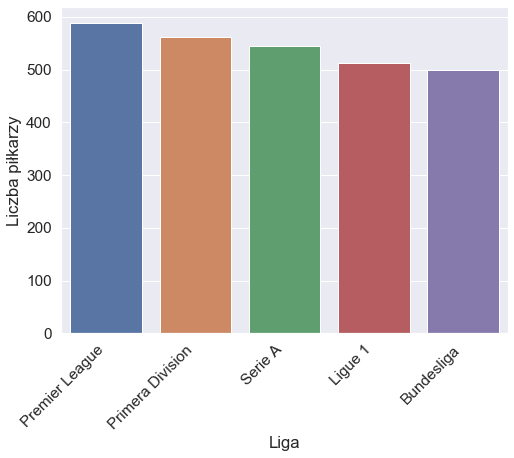

In [1012]:
#Countplot leagues
fig = plt.figure(figsize = (8,6))
chart = sns.countplot(x = 'league',
              data = data,
              order = data['league'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel='Liga', ylabel='Liczba piłkarzy')
plt.show()

Jedynie w Bundeslidze liczba zaspołów biorących udział w rozgrywkach jest mniejsza niż 20 (18), co przekłada się na to, że właśnie z tej ligi najmniejsza liczba piłkarzy znajduje się w zbiorze danych. Różnice pomiędzy licznościami nie są duże i mieszą się w przedziale od 500 do prawie 600. Największa liczba graczy ze zbioru występuje na co dzień w Premier League.

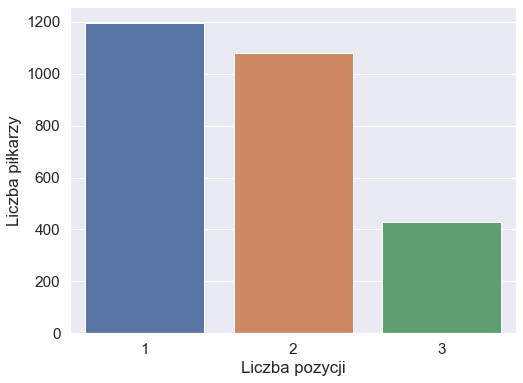

In [1008]:
#Countplot number of positions
fig = plt.figure(figsize = (8,6))
chart = sns.countplot(x = 'number_of_positions',
              data = data,
              order = data['number_of_positions'].value_counts().index)
chart.set(xlabel='Liczba pozycji', ylabel='Liczba piłkarzy')
plt.show()

Powyższy wykres odnosi się do liczby głównych pozycji na których występuje gracz (od 1 do 3). Jak można zauważyć grających głównie na 1 pozycji jest najwięcej, jednak liczba występujących na 2 pozycjach nie jest znacznie mniejsza. W przypadku graczy, którzy są najbardziej wszeschstronni (3 pozycje), można zauważyć, że jest ich znacznie mniej. W związku z rzadkością piłkarzy występujących na większej liczbie pozycji niż 2, można przypuszczać, że są oni opłani lepiej.

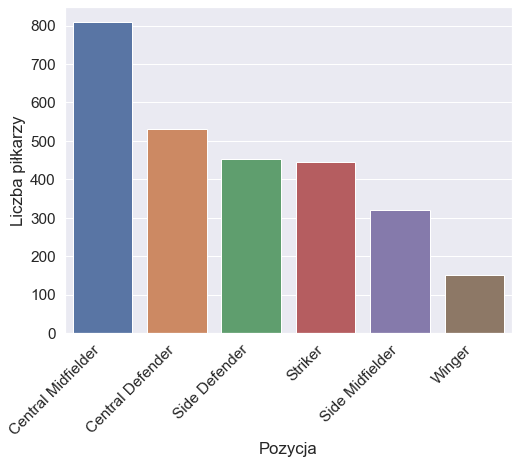

In [1011]:
#Countplot general positions
fig = plt.figure(figsize = (8,6))
chart = sns.countplot(x = 'general_position',
              data = data,
              order = data['general_position'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel='Pozycja', ylabel='Liczba piłkarzy')

plt.show()

Główną pozycją największej ilości graczy z 5 największych lig jest "środkowy pomocnik". Ponad 300 graczy więcej wybrało pozycję w okolicach środka boiska, aniżeli drugiej najczęściej wybieranje jaką jest środkowy obrońca. Pozycją, która jest najrzadziej wybierana przez piłkarzy jako główna jest skrzydłowy. Jeśli weźmiemy pod uwagę to, że dane te dotyczą 5 lig to liczba skrzydłowych może wskazywać na ich niedobór, w związku z czym mogą oni być lepiej opłacani.

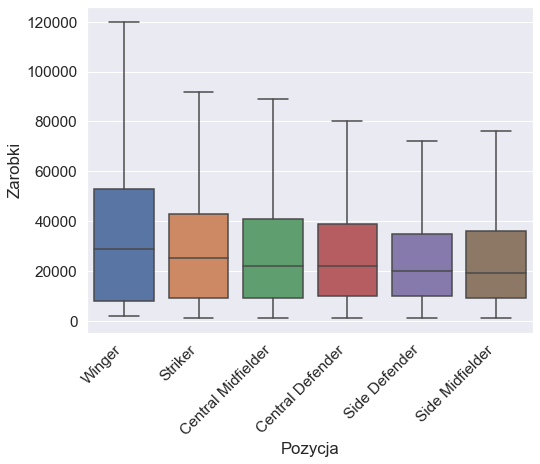

In [1014]:
fig = plt.figure(figsize = (8,6))
chart = sns.boxplot(data['general_position'],data['wage_eur'],showfliers=False)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel='Pozycja', ylabel='Zarobki')
plt.show()

Na powyższym wykresie zostały przedstawione rozkłady zarobków na poszczególnych pozycjach we wszytkich ligach, jednak w celu lepszego zobrazowania wykluczone zostały obserwacje odstające, które były tak skrajne, że zabużały skalę. Dolny kwartyl we wszystkich przypadkach jest na podobnym poziomie, jednak w przypadku mediany oraz górnego kwartyla widać już różnice. Wniosek dotyczący większych zarobków dla skrzydłowych, których jest znacznie mniej niż piłkarzy z innych pozycji, okazał się być trafny. Zarówno przeciętny skrzydłowy jak i Ci lepiej opłacani zarabiają więcej niż gracze występujący na pozostałych pozycjach. Do najsłabiej opłacanych graczy należą boczni obrońcy i boczni pomocnicy.

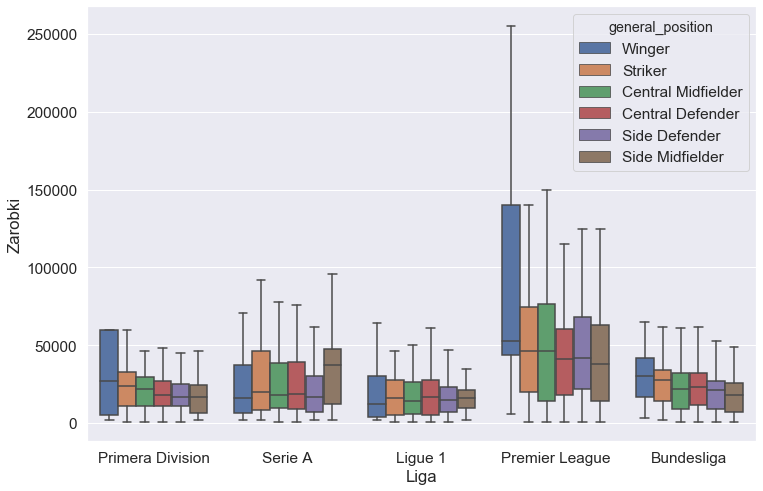

<Figure size 432x288 with 0 Axes>

In [1016]:
fig = plt.figure(figsize = (12,8))
chart = sns.boxplot(x="league", y="wage_eur", hue="general_position", data=data,showfliers=False) 
chart.set(xlabel='Liga', ylabel='Zarobki')
plt.show()

plt.clf()

Powyższy wykres przedstawia to co poprzedni tylko z podziałem na ligi. Premier League znacznie zdominowała pozostałe ligi, w związku z czym skala dla nich jest lekko zabużona. Jednak jak można zauważyć, nie licząć astonomicznych zarobków skrzydłowych w Angielskiej ekstraklasie, dla: Bundesligi, Premier League i Primera Division wykresy prezentują podobny wzorzec jak wykres zaprezentowany bez podziału na ligi. W Ligue 1 mediany są na stosunkowo podobnym poziomie niezależnie od pozycji, a we Włoskiej ekstraklasie to boczni pomocnicy zarabiają więcej niż skrzydłowi. Może mieć to związek z charakterystyką ligi, która jest nastawiona w większym stopniu na defensywe, w związku z czym piłkarze, kórzy mogliby w innych ligach pełnić rolę skrzydłowych, w tym przypadku są bocznymi pomocnikami.

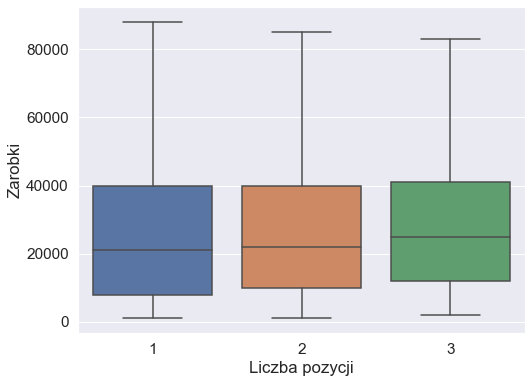

<Figure size 432x288 with 0 Axes>

In [1018]:
#Boxplots depends on number of positions
fig = plt.figure(figsize = (8,6))
chart = sns.boxplot(x="number_of_positions", y="wage_eur", data=data,showfliers=False)
chart.set(xlabel='Liczba pozycji', ylabel='Zarobki')
plt.show()

plt.clf()

Jak się okazuje "uniwersalni" gracze wcale nie są lepiej opłacani. Różnice pomiędzy kwartylami są stosunkowo małe.

<h2>3. Determinanty zarobków piłkarzy</h2>
    
Pora odpowiedzieć na pytanie, które ze zmiennych wpływają w stopniu istotnym na zarobki piłkarzy w wybranych ligach. W tym celu została wykorzystana Regresja wieloraka, za pomocą której bada się zależność zmiennej objaśnianej od co najmniej dwóch zmiennych objaśniających. Dobór zmiennych do modelu został wykonany za pomocą propagacji wstecznej, jednak wcześniej zbiór zmiennych został ograniczony do łącznie 20 z wykorzystaniem rekurencyjnej eliminacji cech. Pozwoliło to na dokładniejszą analizę dzięki zmniejszonej liczbie zmiennych. Ponadto przy badaniu koincydencji zostały wykorzystane macierze korelacji, które również pozwoliły na wgląd w zależności pomiędzy cechami.

<h3>3.1 Przygotowanie danych</h3>

W celu odpowiedniego przygotowania zbioru danych niepotrzebne kolumny zostały usunięte, zaliczają się do nich: imię i nazwisko piłkarza, data urodzenia, wzrost, waga, narodowość, preferowana stopa, praca w obronie i ataku, do kiedy ważny kontrakt, pozycja na boisku w drużynie, pozycje na jakich może występować gracz, główna pozycja. Z wymienionych zmiennych ta dotycząca narodowości mogłaby się okazać istotna, jednak aby uniknąć wyników obarczonych błędem powinien zostać dobrany szerszy kontekst (więcej lig), w związku z czym nie została ona uwzględniona. Następnie zmienna dotycząca przynależności do jednej z 6 wybranych ogólnych pozycji została zamieniona na zmienne zero-jedynkowe i usunięto kolumnę "Striker", aby uniknąć współliniowości. W ostatnim etapie dane zostały podzielone w zależności od ligi i przeprowadzono dla nich propagacje wsteczną.

In [518]:
#Remove useless columns and change general position to dummy variables
data_regression = data.drop(columns = ["short_name", "long_name", "dob", "height_cm", "weight_kg", "nationality",
                     "club", "preferred_foot", "work_rate","contract_valid_until","team_position", "player_positions",
                                      "main_position"])
dummy = pd.get_dummies(data_regression['general_position'])
data_regression = data_regression.merge(dummy, left_index = True, right_index = True)
data_regression = data_regression.drop(columns = ["general_position","Striker"])

In [565]:
#Select 20 most useful variables
def selecting_variables(data, league):
    data = data.loc[data['league'] == league]
    data = data.drop(columns = "league")
    data_regression_vars=data.columns.values.tolist()
    
    y=['wage_eur']
    X=[i for i in data_regression_vars if i not in y]

    lin_regression = LinearRegression()
    rfe = RFE(lin_regression, 18)
    rfe = rfe.fit(data.drop(columns = "wage_eur"), data['wage_eur'].values.ravel())
    result = [x for x, y in zip(X, rfe.support_) if y]
    data = data.loc[:,y + ['value_eur']+result ]
    
    return(data)

#Split the data set by league 
data_regression_premier = selecting_variables(data_regression, "Premier League")
data_regression_bundes = selecting_variables(data_regression, "Bundesliga")
data_regression_primera = selecting_variables(data_regression, "Primera Division")
data_regression_serie = selecting_variables(data_regression, "Serie A")
data_regression_ligue = selecting_variables(data_regression, "Ligue 1")

In [568]:
#Building optimal model based on Backward Elimination
def backward_elimination(data,sl):
    x = data.iloc[:,1:]
    x.insert(0, "const",1)
    y = data.iloc[:, 0]
    x_opt = x
    
    while sl != 0:
        regressor_OLS = sm.OLS(endog = y, exog = x_opt).fit()
        if sl < regressor_OLS.pvalues.max():
            max_index = np.where(regressor_OLS.pvalues == regressor_OLS.pvalues.max())
            x_opt = x_opt.drop(x_opt.columns[max_index], axis=1)
        else:
            sl = 0
    return x_opt

x_opt_premier =backward_elimination(data_regression_premier,0.05)
x_opt_bundes = backward_elimination(data_regression_bundes,0.05)
x_opt_primera = backward_elimination(data_regression_primera,0.05)
x_opt_serie = backward_elimination(data_regression_serie,0.05)
x_opt_ligue = backward_elimination(data_regression_ligue,0.05)

<h3>3.2 Premier League - determinanty </h3>

Jako pierwsza została zbadana Angielska esktraklasa, która charakteryzuje się największymi zarobkami spośród wybranych lig. Poniżej została zaprezentowana tabela z podstawowymi statystykami dla zmiennych wybranych za pomocą propagacji wstecznej.

In [680]:
#Describe selected variables
data_regression_premier.drop(columns = ["Central Defender", "Central Midfielder", "Side Defender", "Side Midfielder",
                                       "Winger"]).describe()

,wage_eur,value_eur,age,overall,potential,skill_moves,pace,shooting,dribbling,attacking_finishing,movement_acceleration,movement_sprint_speed,movement_reactions,power_shot_power,power_long_shots
count,589.000000,5.890000e+02,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,52906.621392,1.031412e+07,24.699491,73.358234,79.047538,2.899830,69.032258,58.543294,69.276740,55.612903,68.889643,69.096774,70.105263,66.787776,58.052632
std,48271.304277,1.299618e+07,4.258207,7.841696,5.401037,0.738966,11.826293,14.635256,10.723321,16.767911,12.269218,11.975846,9.741862,13.507271,16.075786
min,1000.000000,7.000000e+04,17.000000,51.000000,65.000000,2.000000,29.000000,21.000000,33.000000,13.000000,29.000000,29.000000,40.000000,25.000000,14.000000
25%,19000.000000,1.600000e+06,21.000000,69.000000,75.000000,2.000000,62.000000,48.000000,63.000000,43.000000,61.000000,62.000000,64.000000,58.000000,47.000000
50%,43000.000000,7.000000e+06,25.000000,75.000000,79.000000,3.000000,70.000000,61.000000,71.000000,57.000000,69.000000,69.000000,72.000000,70.000000,62.000000
75%,71000.000000,1.250000e+07,28.000000,78.000000,83.000000,3.000000,77.000000,70.000000,77.000000,69.000000,77.000000,77.000000,77.000000,77.000000,71.000000
max,370000.000000,9.000000e+07,36.000000,91.000000,92.000000,5.000000,96.000000,91.000000,92.000000,94.000000,97.000000,96.000000,93.000000,91.000000,90.000000


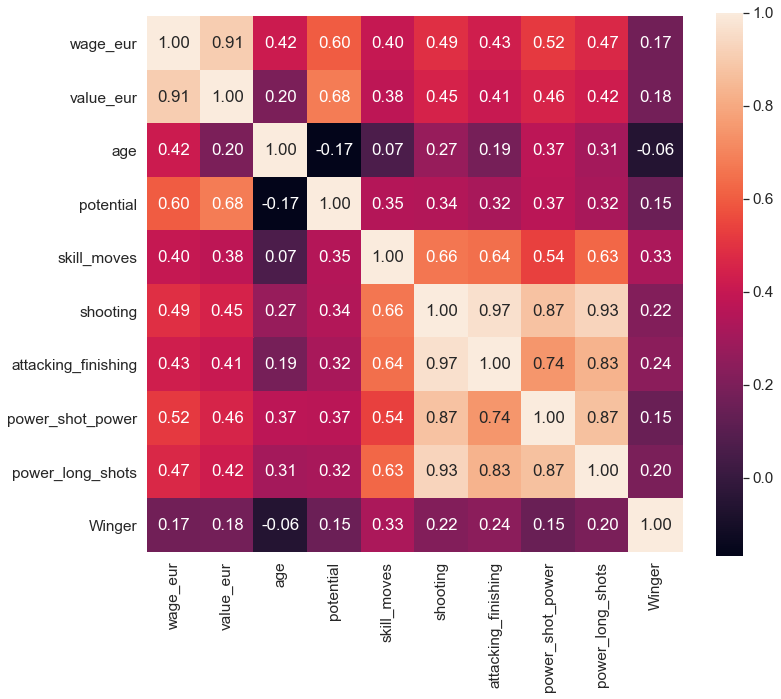

In [1021]:
#Correlation heatmap
def corrPlot(data):
    cols = data.columns.tolist()
    fig = plt.figure(figsize = (12,10))
    cm = np.corrcoef(data[cols].values.T)
    sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f',yticklabels = cols, xticklabels = cols)
    plt.show()
corrPlot(pd.concat([data_regression_premier.iloc[:,0], x_opt_premier.iloc[:,1:]], axis=1))

Jak możemy zauważyć z powyższego wykresu zmienna dotycząca zarobków piłkarzy jest skorelowana dodatnie z pozostałymi, przy czym największą osiąga z wartością piłkarza. Warto zauważyć, że większość wartości korelacji pomiędzy zmiennymi objasniającymi, a objaśniającą oscyluje w okolicacj 0,5 co wydaje się być wynikiem stosunkowo dużym, wyjatkiem jest "Winger", z którym osiąga zaledwie wynik 0,17. Jeśli chodzi o korelacje pomiędzy zmiennymi endogenicznymi to w większości przypadków wahają się w okolicach 0,3, wyjątkiem są statystyki pochodne umiejętności atakującego oraz sztuczki, pomiędzy którymi występuję bardzo silna zależność. Ze względu na brak koincydencji, w przypadku zmienych dotyczących umiejętności atakowania, zostały one usunięte z modelu.

In [996]:
OLS(data_regression_premier.iloc[:, 0],x_opt_premier.iloc[:,[0,1,2,3,4,9]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wage_eur   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     981.7
Date:                Sun, 07 Jun 2020   Prob (F-statistic):          3.81e-281
Time:                        22:40:12   Log-Likelihood:                -6526.9
No. Observations:                 589   AIC:                         1.307e+04
Df Residuals:                     583   BIC:                         1.309e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.481e+05    1.6e+04     -9.243      0.000    -1.8e+05   -1.17e+05
value_eur       0.0028    7.7e-05     36.178      0.000       0.003       0.003
age          3243.4181    173.223     18.724      0.000    2903.202    3583.635
potential    1047.0841    183.484      5.707      0.000     686.714    1407.455
skill_moves  3130.4074   1004.219      3.117      0.002    1158.080    5102.735
Winger       4681.1225   2933.260      1.596      0.111   -1079.922    1.04e+04
==============================================================================
Omnibus:                      164.399   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              950.659
Skew:                           1.102   Prob(JB):                    3.69e-207
Kurtosis:                       8.821   Cond. No.                     4.08e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Jak można zauważyć ostatecznie w modelu wzięte pod uwagę zostały wartość piłkarza, wiek, potencjał, umiejętności techniczne oraz to czy zawodnik jest skrzydłowym. I tak 100 euro wartości piłarza przekłada się na 0,28 euro zarobków, im starszy piłkarz o rok to zarabia około 3243 euro więcej, a bycie skrzydłowym spowoduje wzrost naszych zarobków o 4681 euro miesięcznie. Jeśli chodzi o potencjał i umiejętności techniczne to można śmiało żałożyć, że młodzi piłkarze grający widowiskowo i skutecznie będą zarabiali więcej. Wariancja zmiennej egzogenicznej została wyjaśniona w 89% co jest satysfakcjonującym wynikiem.

<h3>3.3 Bundesliga - determinanty </h3>

Następna w kolejności jest Niemiecka esktraklasa, która posiada najmniejszą ilość zespołów w lidze, w związku z czym liczba piłkarzy również jest najmniejsza. Poniżej została zaprezentowana tabela z podstawowymi statystykami dla zmiennych wybranych za pomocą propagacji wstecznej.

In [1036]:
#Describe selected variables
data_regression_bundes.describe()

,wage_eur,value_eur,overall,potential,weak_foot,pace,dribbling,defending,physic,attacking_volleys,skill_ball_control,movement_acceleration,movement_sprint_speed,defending_marking,defending_standing_tackle,Central Defender,Central Midfielder,Side Defender,Side Midfielder,Winger
count,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,27452.000000,7.992580e+06,72.484000,78.304000,3.178000,69.648000,68.756000,56.774000,67.490000,52.936000,70.044000,69.524000,69.746000,56.27200,57.444000,0.192000,0.298000,0.168000,0.15200,0.036000
std,28907.906013,9.560224e+06,6.923121,4.981286,0.659687,10.847092,9.926406,17.822745,9.783524,16.211277,9.191029,11.330233,11.245016,18.68594,20.072485,0.394268,0.457838,0.374241,0.35938,0.186477
min,1000.000000,0.000000e+00,55.000000,64.000000,2.000000,31.000000,36.000000,20.000000,33.000000,15.000000,38.000000,32.000000,29.000000,14.00000,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,10000.000000,1.375000e+06,68.000000,75.000000,3.000000,64.000000,64.000000,40.000000,61.000000,40.000000,65.000000,64.000000,64.000000,42.00000,39.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,22000.000000,5.500000e+06,74.000000,78.000000,3.000000,70.000000,70.000000,61.000000,69.000000,54.000000,71.000000,69.000000,69.000000,60.00000,64.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,32000.000000,1.050000e+07,77.000000,82.000000,4.000000,77.000000,76.000000,72.000000,75.000000,65.000000,76.000000,77.000000,77.000000,72.00000,74.000000,0.000000,1.000000,0.000000,0.00000,0.000000
max,235000.000000,6.450000e+07,89.000000,92.000000,5.000000,93.000000,90.000000,89.000000,87.000000,90.000000,91.000000,94.000000,95.000000,90.00000,89.000000,1.000000,1.000000,1.000000,1.00000,1.000000


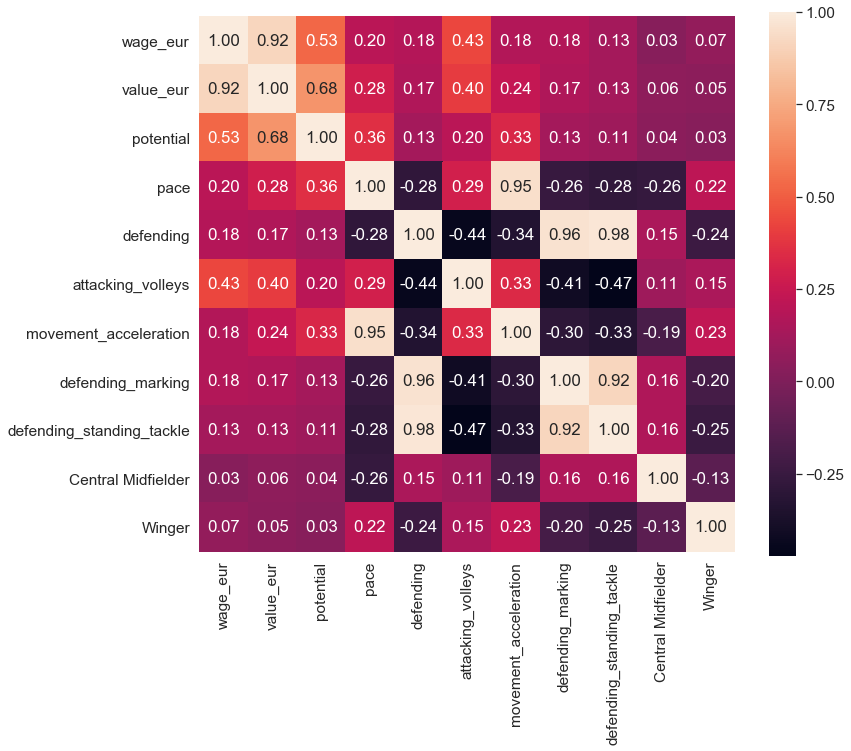

In [1022]:
corrPlot(pd.concat([data_regression_bundes.iloc[:,0], x_opt_bundes.iloc[:,1:]], axis=1))

Tym razem również zmienna dotycząca zarobków piłkarzy jest skorelowana dodatnie z pozostałymi, przy czym największą osiąga z wartością piłkarza. Jednak w tym przypadku korelacje pomiędzy zmienną objaśnianą, a zmiennymi objaśniającymi są mniejsze i oscylują w okolicach 0,2. Ze względu na brak koincydencji, zmienne: potencjału, prędkości, poruszania się po boisku, konkretnych umiejętności bronienia oraz pozycji środkowego pomocnika zostały usunięte z modelu.

In [588]:
OLS(data_regression_bundes.iloc[:, 0],x_opt_bundes.iloc[:,[0,1,4,5,10]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wage_eur   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     743.6
Date:                Thu, 04 Jun 2020   Prob (F-statistic):          1.09e-207
Time:                        14:05:37   Log-Likelihood:                -5358.1
No. Observations:                 500   AIC:                         1.073e+04
Df Residuals:                     495   BIC:                         1.075e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.627e+04   3410.327     -4.770      0.000    -2.3e+04   -9565.402
value_eur             0.0025   6.21e-05     41.056      0.000       0.002       0.003
defending           176.6156     34.674      5.094      0.000     108.489     244.742
attacking_volleys   247.9433     40.158      6.174      0.000     169.042     326.844
Winger             5381.2239   2721.118      1.978      0.049      34.858    1.07e+04
==============================================================================
Omnibus:                       95.746   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1331.538
Skew:                           0.330   Prob(JB):                    7.25e-290
Kurtosis:                      10.967   Cond. No.                     8.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ostatecznie w modelu wzięte pod uwagę zostały wartość piłkarza, umiejętność bronienia, umiejętność strzelania wolejem oraz to czy zawodnik jest skrzydłowym. I tak 100 euro wartości piłarza przekłada się na 0,25 euro zarobków, a bycie skrzydłowym spowoduje wzrost naszych zarobków o 4681 euro miesięcznie. Ponadto można zauważyć, że w tej lidze najlepiej opłacanymi umiejętnościami są: bronienie oraz strzały z powietrza. Wariancja zmiennej egzogenicznej została wyjaśniona w 85% co jest wynikiem niewiele gorszym od poprzedniego, jednak wciąż satysfakcjonującym.

<h3>3.4 Primera Division - determinanty </h3>

W tym przypadku zbadana zostanie Hiszpańska ekstraklasa, która charakteryzuje się technicznym stylem gry, w związku z czym można przypuszczać, że zmienne dotyczące techniki bedą wpływały na wysokość zarobków. Poniżej została zaprezentowana tabela z podstawowymi statystykami dla zmiennych wybranych za pomocą propagacji wstecznej.

In [1035]:
#Describe selected variables
data_regression_primera.describe()

,wage_eur,value_eur,age,overall,potential,weak_foot,skill_moves,passing,dribbling,physic,attacking_crossing,attacking_short_passing,skill_dribbling,skill_ball_control,power_stamina,power_strength,Central Defender,Side Defender,Side Midfielder,Winger
count,561.000000,5.610000e+02,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,34272.727273,9.536765e+06,25.146168,73.675579,78.987522,3.114082,2.846702,64.821747,69.039216,66.224599,61.390374,71.245989,67.663102,71.932264,67.406417,66.415330,0.196078,0.171123,0.140820,0.044563
std,59866.835452,1.194563e+07,4.267823,6.793768,5.084099,0.627778,0.725574,10.404684,10.115859,10.923083,14.939850,8.262658,12.722542,8.762076,12.542025,13.113395,0.397383,0.376953,0.348146,0.206527
min,1000.000000,1.600000e+05,17.000000,57.000000,62.000000,2.000000,2.000000,36.000000,39.000000,33.000000,20.000000,46.000000,22.000000,40.000000,29.000000,29.000000,0.000000,0.000000,0.000000,0.000000
25%,10000.000000,1.500000e+06,22.000000,69.000000,76.000000,3.000000,2.000000,58.000000,64.000000,59.000000,52.000000,65.000000,62.000000,66.000000,60.000000,60.000000,0.000000,0.000000,0.000000,0.000000
50%,20000.000000,6.000000e+06,25.000000,74.000000,79.000000,3.000000,3.000000,65.000000,70.000000,68.000000,64.000000,72.000000,70.000000,73.000000,68.000000,68.000000,0.000000,0.000000,0.000000,0.000000
75%,28000.000000,1.200000e+07,28.000000,79.000000,83.000000,3.000000,3.000000,72.000000,76.000000,74.000000,73.000000,77.000000,77.000000,78.000000,76.000000,75.000000,0.000000,0.000000,0.000000,0.000000
max,565000.000000,9.550000e+07,38.000000,94.000000,94.000000,5.000000,5.000000,92.000000,96.000000,89.000000,91.000000,92.000000,97.000000,96.000000,93.000000,93.000000,1.000000,1.000000,1.000000,1.000000


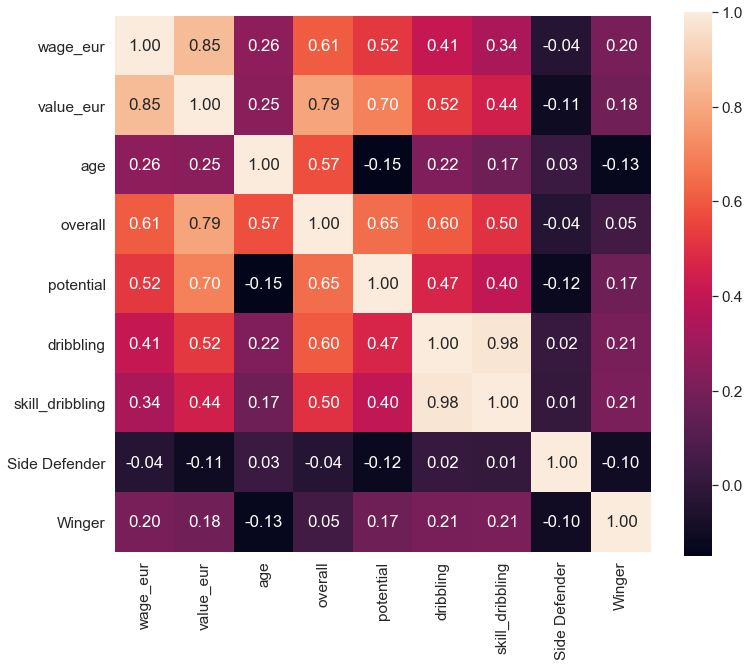

In [1023]:
corrPlot(pd.concat([data_regression_primera.iloc[:,0], x_opt_primera.iloc[:,1:]], axis=1))

Zgodnie z przypuszczeniami za pomocą propagacji wstecznej dobrane zostały dwie zmienne dotyczące techniki, jednak ostatecznie nie znalazły się one w modelu. Podobnie jak w lidze niemieckiej korelacje pomiędzy zmienną objaśnianą, a zmiennymi objaśniającymi są mniejsze i w większości przypadków nie przekraczają 0,5. Ze względu na brak koincydencji, zmienne: umiejętności ogólne, umiejętności techniczne, czy gracz jest bocznym obrońcą oraz potencjał zostały usunięte z modelu.

In [597]:
x_opt_primera.insert(0, "const",1)
OLS(data_regression_primera.iloc[:, 0],x_opt_primera.iloc[:,[0,1,2,8]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wage_eur   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     517.4
Date:                Thu, 04 Jun 2020   Prob (F-statistic):          1.45e-160
Time:                        14:12:07   Log-Likelihood:                -6593.0
No. Observations:                 561   AIC:                         1.319e+04
Df Residuals:                     557   BIC:                         1.321e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.842e+04   7985.729     -3.559      0.000   -4.41e+04   -1.27e+04
value_eur      0.0041      0.000     35.912      0.000       0.004       0.004
age          888.5374    320.602      2.771      0.006     258.801    1518.274
Winger      1.827e+04   6523.815      2.800      0.005    5454.576    3.11e+04
==============================================================================
Omnibus:                      124.458   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1053.357
Skew:                           0.711   Prob(JB):                    1.85e-229
Kurtosis:                       9.561   Cond. No.                     9.66e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ostatecznie w modelu wzięte pod uwagę zostały wartość piłkarza, wiek oraz to czy zawodnik jest skrzydłowym. I tak 100 euro wartości piłarza przekłada się na 0,41 euro zarobków, a bycie skrzydłowym spowoduje wzrost naszych zarobków o aż 18270 euro miesięcznie. Wariancja zmiennej egzogenicznej została wyjaśniona w 74% co w porównaniu z poprzednimi wynikami jest znacznie gorszym rezultatem, jednak wciąż dobrym.

<h3>3.5 Serie A - determinanty </h3>
    
Kolejny model został utworzony dla Włoskiej ekstraklasy, która charakteryzuje się defensywnym stylem gry, w związku z czym można przypuszczać, że zmienne dotyczące obrony bedą wpływały na wysokość zarobków. Poniżej została zaprezentowana tabela z podstawowymi statystykami dla zmiennych wybranych za pomocą propagacji wstecznej.

In [1034]:
#Describe selected variables
data_regression_serie.describe()

,wage_eur,value_eur,age,overall,potential,weak_foot,skill_moves,pace,dribbling,physic,skill_dribbling,movement_acceleration,movement_sprint_speed,power_stamina,power_strength,mentality_aggression,Central Defender,Central Midfielder,Side Defender,Side Midfielder
count,545.000000,5.450000e+02,545.000000,545.00000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,30889.908257,7.849257e+06,25.488073,72.66789,77.554128,3.126606,2.823853,67.988991,68.627523,66.877064,67.845872,68.207339,67.812844,67.822018,67.337615,64.554128,0.209174,0.335780,0.130275,0.088073
std,35839.906347,1.009305e+07,4.343727,6.85765,5.720618,0.659021,0.708522,11.158281,10.293968,9.670563,12.034345,11.547979,11.529606,11.794638,12.228814,14.254814,0.407093,0.472696,0.336915,0.283662
min,1000.000000,7.000000e+04,16.000000,51.00000,59.000000,2.000000,2.000000,32.000000,34.000000,38.000000,25.000000,31.000000,31.000000,31.000000,30.000000,23.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,1.200000e+06,22.000000,69.00000,74.000000,3.000000,2.000000,61.000000,62.000000,61.000000,62.000000,61.000000,62.000000,61.000000,60.000000,56.000000,0.000000,0.000000,0.000000,0.000000
50%,19000.000000,4.600000e+06,25.000000,73.00000,78.000000,3.000000,3.000000,68.000000,70.000000,68.000000,70.000000,68.000000,68.000000,69.000000,68.000000,67.000000,0.000000,0.000000,0.000000,0.000000
75%,40000.000000,1.000000e+07,28.000000,77.00000,82.000000,3.000000,3.000000,76.000000,76.000000,74.000000,76.000000,76.000000,75.000000,75.000000,75.000000,75.000000,0.000000,1.000000,0.000000,0.000000
max,405000.000000,7.650000e+07,37.000000,93.00000,93.000000,5.000000,5.000000,94.000000,91.000000,88.000000,92.000000,95.000000,93.000000,95.000000,95.000000,91.000000,1.000000,1.000000,1.000000,1.000000


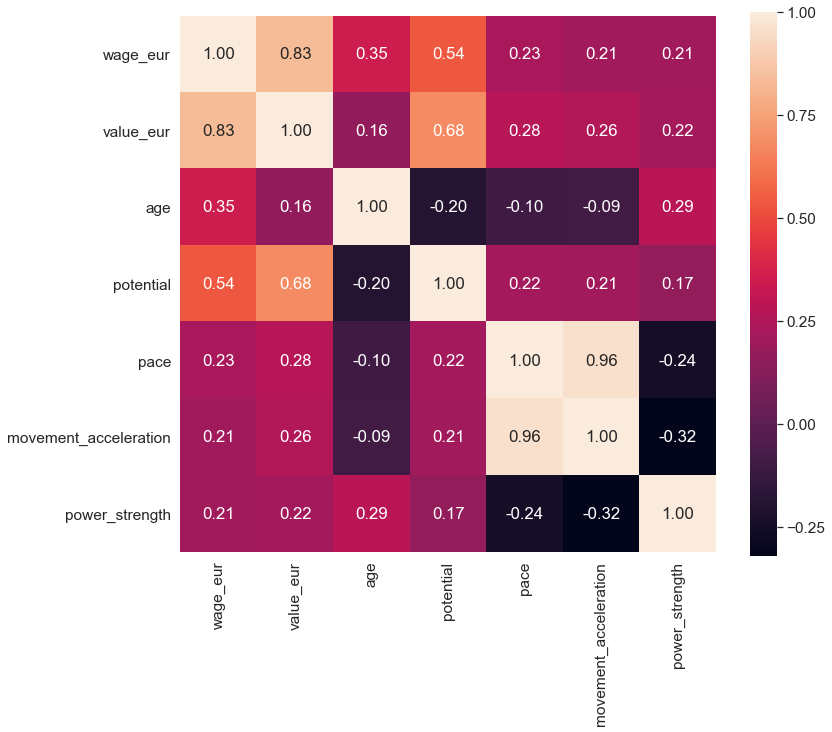

In [1024]:
corrPlot(pd.concat([data_regression_serie.iloc[:,0], x_opt_serie.iloc[:,1:]], axis=1))

Tym razem przypuszczenia co do tego, że zmienne dotyczące umiejętności defensywnych okażą się istotne były błędne. Podobnie jak w dwóch poprzednich przypadkach korelacje pomiędzy zmienną objaśnianą, a zmiennymi objaśniającymi są mniejsze i w większości przypadków oscylują w okolicach 0,25. Ze względu na brak koincydencji, zmienne: przyśpieszenie oraz siła nie zostały uwzględnione w modelu.

In [994]:
OLS(data_regression_serie.iloc[:, 0],x_opt_serie.iloc[:,[0,1,2,3,4]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wage_eur   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     393.1
Date:                Sun, 07 Jun 2020   Prob (F-statistic):          2.26e-158
Time:                        22:39:39   Log-Likelihood:                -6116.4
No. Observations:                 545   AIC:                         1.224e+04
Df Residuals:                     540   BIC:                         1.226e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.235e+04   1.92e+04     -4.809      0.000    -1.3e+05   -5.46e+04
value_eur      0.0026      0.000     21.387      0.000       0.002       0.003
age         2065.3008    203.952     10.126      0.000    1664.665    2465.937
potential    549.3480    207.251      2.651      0.008     142.230     956.466
pace         115.7752     73.670      1.572      0.117     -28.940     260.490
==============================================================================
Omnibus:                      513.932   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39484.797
Skew:                           3.801   Prob(JB):                         0.00
Kurtosis:                      44.000   Cond. No.                     3.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

W modelu wzięte pod uwagę zostały wartość piłkarza, wiek, potencjał oraz przyśpieszenie. I tak wzrost o 100 euro wartości piłkarza przekłada się na wzrost o 0,26 euro jego zarobków, a im starszy o rok tym jego zarobki zwiększają się o 2065 euro. Ponadto młodzi i szybcy piłkarze zarabiają istotnie więcej. Wariancja zmiennej egzogenicznej została wyjaśniona w 74% co jest praktycznie identycznym wynikiem jak w modelu dotyczącym Primera Division.

<h3>3.6 Ligue 1 - determinanty </h3>

Jako ostatnia pod uwagę została wzięta Francuska ekstraklasa, która uważana jest za najsłabszą z wybranych. Poniżej została zaprezentowana tabela z podstawowymi statystykami dla zmiennych wybranych za pomocą propagacji wstecznej.

In [1033]:
#Describe selected variables
data_regression_ligue.describe()

,wage_eur,value_eur,overall,potential,skill_moves,pace,shooting,physic,attacking_short_passing,attacking_volleys,movement_acceleration,movement_sprint_speed,movement_reactions,mentality_penalties,mentality_composure,Central Defender,Central Midfielder,Side Defender,Side Midfielder,Winger
count,513.000000,5.130000e+02,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,20760.233918,5.602359e+06,70.748538,77.274854,2.846004,68.927875,56.173489,65.654971,68.097466,50.666667,68.900585,68.933723,66.286550,55.660819,65.413255,0.175439,0.296296,0.181287,0.103314,0.068226
std,25450.070173,8.910175e+06,6.470571,4.919716,0.682988,11.141169,14.048435,10.012095,8.668271,14.806829,11.514760,11.328523,8.503547,11.569675,9.741622,0.380713,0.457069,0.385631,0.304665,0.252380
min,1000.000000,0.000000e+00,56.000000,64.000000,2.000000,31.000000,25.000000,36.000000,34.000000,11.000000,32.000000,31.000000,40.000000,24.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6000.000000,9.250000e+05,66.000000,74.000000,2.000000,63.000000,45.000000,59.000000,63.000000,38.000000,62.000000,63.000000,60.000000,46.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,3.300000e+06,72.000000,77.000000,3.000000,70.000000,58.000000,67.000000,69.000000,52.000000,69.000000,69.000000,68.000000,56.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,25000.000000,7.000000e+06,75.000000,80.000000,3.000000,77.000000,67.000000,73.000000,74.000000,62.000000,77.000000,77.000000,73.000000,65.000000,72.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,1.055000e+08,92.000000,95.000000,5.000000,96.000000,86.000000,87.000000,90.000000,90.000000,96.000000,96.000000,92.000000,90.000000,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000


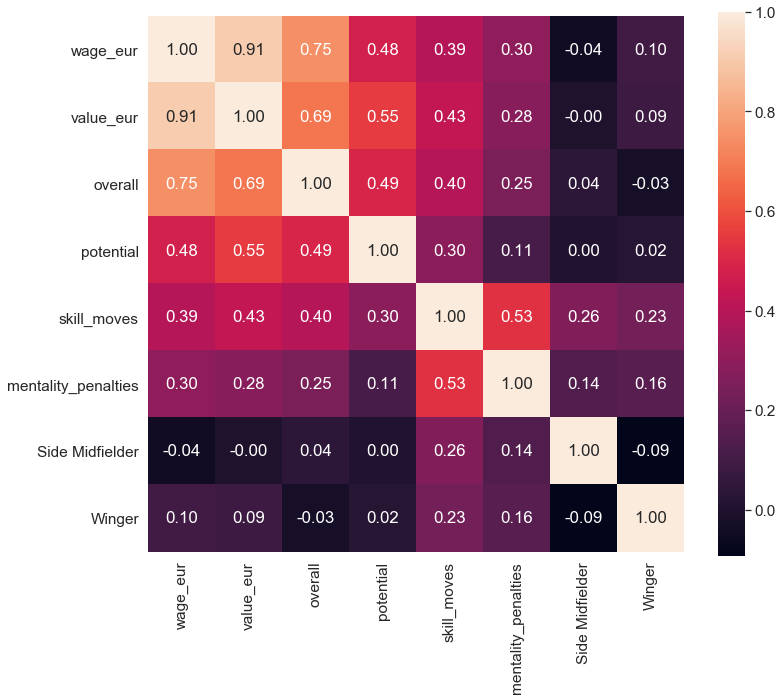

In [1025]:
corrPlot(pd.concat([data_regression_ligue.iloc[:,0], x_opt_ligue.iloc[:,1:]], axis=1))

Tym razem przypuszczenia co do tego, że zmienne dotyczące umiejętności defensywnych okażą się istotne były błędne. Podobnie jak w dwóch poprzednich przypadkach korelacje pomiędzy zmienną objaśnianą, a zmiennymi objaśniającymi są mniejsze i w większości przypadków oscylują w okolicach 0,25. Ze względu na brak koincydencji, zmienne: przyśpieszenie oraz siła nie zostały uwzględnione w modelu.

In [590]:
OLS(data_regression_ligue.iloc[:, 0],x_opt_ligue.iloc[:,[0,1,2,5,6,7]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wage_eur   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     633.8
Date:                Thu, 04 Jun 2020   Prob (F-statistic):          1.95e-215
Time:                        14:07:46   Log-Likelihood:                -5423.4
No. Observations:                 513   AIC:                         1.086e+04
Df Residuals:                     507   BIC:                         1.088e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6.147e+04   6309.561     -9.743      0.000   -7.39e+04   -4.91e+04
value_eur               0.0021   6.62e-05     31.664      0.000       0.002       0.002
overall               933.7696     90.453     10.323      0.000     756.061    1111.478
mentality_penalties    84.2472     38.894      2.166      0.031       7.834     160.661
Side Midfielder     -4483.3449   1402.069     -3.198      0.001   -7237.926   -1728.764
Winger               3055.8149   1712.832      1.784      0.075    -309.308    6420.938
==============================================================================
Omnibus:                      237.344   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7358.740
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                      21.348   Cond. No.                     1.58e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Jak można zauważyć ostatecznie w modelu wzięte pod uwagę zostały wartość piłkarza, ocena ogólna, mentalność przy karnych, czy zawodnik jest bocznym pomocnikiem oraz to czy zawodnik jest skrzydłowym. I tak wzrost o 100 euro wartości piłarza przekłada się na wzrost o 0,21 euro jego zarobków, im lepszy piłkarz o punkt oceny ogólnej to zarabia około 934 euro więcej, a bycie skrzydłowym spowoduje wzrost naszych zarobków o 3056 euro miesięcznie. Co ciekawe gracze, którzy są nieznacznie bliżej ustawiani własnej bramki niż skrzydłowi na boisku zarabiają już średnio o 4483 euro mniej. Ponadto gracze, którzy są w stanie zachować zimną krew podczas strzelania karynch zarabiają istotnie więcej. Wariancja zmiennej egzogenicznej została wyjaśniona w 86% co jest drugim najwyższym wynikiem.

<h2>4. Klasyfikacja boiskowa piłkarzy</h2>

Niniejszy rozdział poświęcony jest klasyfikacji, gdzie za pomocą algorytmów: K najbliższych sąsiadów (KNN), Drzew decyzyjnych (Decision Tree) oraz Lasów losowych (Random Forest) przypisano na podstawie statystyk piłkarzy do pozycji. Zbiór danych podzielono na zbiór uczący, który został wykorzystany przy dostrajaniu parametrów modelu oraz zbiór testowy, za pomocą którego została przeprowadzona walidacja oraz porównanie modeli. W celu weryfikacji skuteczności wykorzystano metryke dokładności (Accuracy), która wyliczana jest na podstawie ilorazu trafnych klasyfikacji ze wszystkimi klasyfikacjami. Dostrajanie parametrów zostało wykonane metodą przeszukiwania siatki z 10-krotnym sprawdzianem krzyżowym. Przed przystąpieniem do uczenia modeli z danych zostały porzucone zmienne dotyczące: imienia i nazwiska, daty urodzenia, klubu, preferowanej stopy, pracy w ataku i obronie, ile jeszcze zostało kontraktu, pozycja w drużynie, pozycje na których występuje gracz,liga w której występuje gracz oraz główna pozycja gracza.

In [599]:
#Remove useless columns
data_classification = data.drop(columns = ["short_name", "long_name", "dob", "nationality", "club", "preferred_foot",
                                       "work_rate","contract_valid_until","team_position", "player_positions","main_position"])

#Split dataset
X = data_classification.drop(columns = ["general_position","league"])
y = data_classification['general_position']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Poniżej znajdują się funkcje wykorzystywane przy opisywaniu rezultatów badania:
    
* <b>cv_res_frame</b> - wypisanie w formie tabeli optymalnych parametrów oraz średniego wyniku na zbiorze walidacyjnym,

* <b>conf_matrix_plot</b> - utworzenie map ciepła dla macierzy pomyłek zbioru treningowego i testowego,

* <b>train_test_res</b> - wypisanie w formie tabeli dokładności klasyfikacji na zbiorze treningowym i testowym.


In [990]:
#Create frame with cross validation results
def cv_res_frame(gs, index , split = "__",split_str = 1):
    res_frame = pd.DataFrame([gs.best_params_], index = [index])
    res_frame.columns = res_frame.columns.str.split(split).str[split_str]
    return(pd.concat([pd.DataFrame({"Best mean score":[gs.best_score_]}, index = [index]),res_frame], axis = 1))

#Create heatmap for confusion matrices (train and test sets)
def conf_matrix_plot(y_train,y_test, y_pred_train, y_pred_test,labels):
    #Prepare frames with confusion matrices
    df_cm_train = pd.DataFrame(confusion_matrix(y_train, y_pred_train), index = labels,
                      columns = labels)
    df_cm_test = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index = labels,
                      columns = labels)
    #Set plot options
    fig, ax =plt.subplots(1,2,figsize=(13,6))
    fig.tight_layout(pad=5.0)
    
    #Train set heatmap
    train_heatmap = sns.heatmap(df_cm_train, annot=True, fmt = "g", ax = ax[0])
    train_heatmap.set_yticklabels(train_heatmap.get_yticklabels(), rotation=35)
    train_heatmap.set_title('Train set confusion matrix')
    
    #Test set heatmap
    test_heatmap = sns.heatmap(df_cm_test, annot=True, fmt = "g",ax = ax[1])
    test_heatmap.set_yticklabels(test_heatmap.get_yticklabels(), rotation=35)
    test_heatmap.set_title('Test set confusion matrix')
    fig.show()

#Create frame with train and test predictions results
def train_test_res(gs, X_train, y_train, X_test,y_test):
    clf = gs.best_estimator_
    clf.fit(X_train, y_train)
    return(pd.DataFrame({"Train score": [clf.score(X_train,y_train)], "Test score": [clf_knn.score(X_test,y_test)]},
                        index = ["Results"]))

<h3>4.1 KNN - wyniki</h3>

W przypadku algorymtu K najbliższych sąsiadów za pomocą funkcji "make_pipeline" został utworzony estymator, który najpierw standaryzuje dane, a następnie wprowadza je do klasyfikatora KNN. Parametry, które zostały poddane dostrajaniu to:

* <b>leaf_size</b> - rozmiar liści przekazany do BallTree lub KDTree (od 25 do 30),

* <b>n_neighbors</b> - liczba sąsiadów wykorzystywana przez algorytm (od 1 do 30),

* <b>p</b> - parametr mocy dla metryki Minkowskiego (1 lub 2).

Poniżej zaprezentowane w tabeli zostały wyniki metody przeszukiwania siatki.

In [1027]:
#Combining standardisation with the model
pipe_knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier())
#List Hyperparameters that we want to tune.
leaf_size = list(range(25,35))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
params_knn = {"kneighborsclassifier__leaf_size":leaf_size, "kneighborsclassifier__n_neighbors":n_neighbors,
              "kneighborsclassifier__p":p}

#Grid search
gs_knn = GridSearchCV(estimator = pipe_knn, param_grid = params_knn, scoring = 'accuracy', cv = 10)

gs_knn = gs_knn.fit(X_train, y_train)

#Results
cv_res_frame(gs_knn, "KNN CV result")

,Best mean score,leaf_size,n_neighbors,p
KNN CV result,0.806992,25,17,1


Jak można zauważyć w tabeli powyżej dobrane parametry to: wielkość liści = 25, liczba sąsiadów = 17 i p = 1. Ponadto średni wynik dokładności dla tych parametrów wynosi 81% co może zwiastować bardzo dobrą skuteczność modelu. Poniżej znajdują się mapy ciepła macierzy pomyłek dla obu zbiorów.

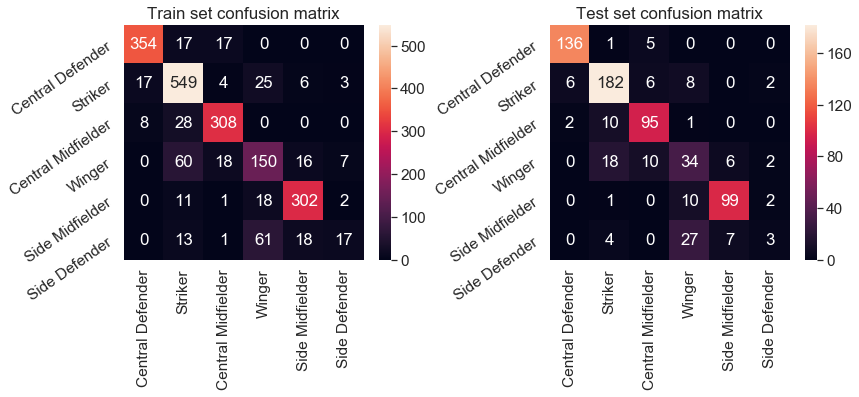

In [1026]:
labels = set(data_classification['general_position'])
y_train_pred = gs_knn.predict(X_train)
y_test_pred = gs_knn.predict(X_test)
conf_matrix_plot(y_train,y_test,y_train_pred,y_test_pred ,labels)

W wierszach znajdują się rzeczywiste wartości, a w kolumnach przewidywane. Zarówno dla zbioru treningowego i testowego wyniki są obiecujące, a wzory co do popełnianych pomyłek zdają się powtarzać. Najwięcej źle sklasyfikowanych graczy to boczni obrońcy, którzy zostali przypisani do skrzydłowych oraz skrzydłowi, którzy zostali przypisani do napastników. Co ciekawe środkowi obrońcy są wyłącznie myleni z środkowymi pomocnikami i napastnikami. Najprawdopodobniej wzrost w znacznym stopniu pomaga rozróżniać obrońców bocznych od środkowych, a niektórzy z nich charakteryzują się wysokimi umiejętnościami w ataku (Ramos, van Dijk), w związku z czym algorytm nie poradził sobie z ich poprawnym przypisaniem. Poniżej znajduje się tabela z wynikami dla obu zbiorów.

In [909]:
train_test_res(gs_knn, X_train, y_train, X_test,y_test)

,Train score,Test score
Results,0.827179,0.810931


Różnica pomiędzy wynikami na danych treningowych i testowych jest nieznaczna. W obu przypadkach wynik wynosi ponad 80% co świadczy zdecydowanie o dużej skuteczności modelu.

<h3>4.2 Drzewo decyzyjne</h3>

Przy drzewie decyzyjnym również wykorzystano funkcję "make_pipeline" za pomocą której został utworzony estymator, który najpierw standaryzuje dane, a następnie wprowadza je do klasyfikatora DecisionTreeClassifier. Parametry, które zostały poddane dostrajaniu to:

* <b>criterion</b> - funkcja mierząca jakość podziału danych w drzewie (gini lub entropy),

* <b>max_features</b> - liczba zmiennych, które należy wziąć pod uwagę przy poszukiwaniu najlepszego podziału (auto lub sqrt),

* <b>max_depth</b> - maksymalna głębokość drzewa (4, 5 lub 6),

* <b>min_samples_split</b> - minimalna liczba próbek wymagana do podziału wewnętrznego węzła (2, 5, 10, 12 lub 15),

* <b>min_samples_leaf</b> - minimalna liczba próbek, które muszą znajdować się w węźle liściowym (1, 2 lub 4).

Ponadto warto zwrócić uwagę na parametr dotyczący maksymalnej głębokości drzewa, którego wartość domyślnie w bibliotece sklearn jest ustawiona na "None" (oznacza to, że może ona być dowolna). W przypadku zbyt dużej głębokości algorytm wykazuje tendencję do przetrenowania, a więc osiąga dużą skuteczność na zbiorze, na którym się uczył, ale w przypadku zetknięcia z nowymi danymi osiąga słaby wynik. Poniżej zaprezentowany został wykres przedstawiający skuteczność modelu na zbiorze treningowym i testowym w zależności od ustawionej maksymalnej głębokości.

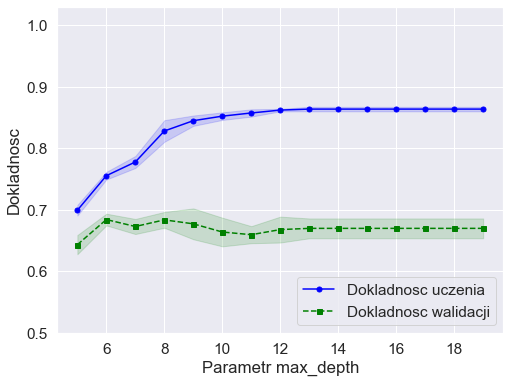

In [1031]:
pipe_random_repair = make_pipeline(StandardScaler(),
            DecisionTreeClassifier(criterion = 'entropy',
                                   min_samples_leaf = 4,
                                   min_samples_split = 10,
                                   max_features = 'auto',
                                   random_state = 1))

param_range = range(5,20)
train_scores, test_scores =validation_curve(estimator = pipe_random_repair,
                                                         X = X_train,
                                                         y = y_train,
                                                         param_name = 'decisiontreeclassifier__max_depth',
                                                         cv = 5,
                                                         param_range = param_range)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores,axis =1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores,axis =1)

fig = plt.figure(figsize = (8,6))
plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'Dokladnosc uczenia')
plt.fill_between(param_range,train_mean + train_std, train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--', marker = 's',
         markersize = 5, label = 'Dokladnosc walidacji')
plt.fill_between(param_range,test_mean + test_std, test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.xlabel('Parametr max_depth')
plt.ylabel('Dokladnosc')
plt.legend(loc = 'lower right')
plt.ylim([0.5,1.03])
plt.show()

Już przy głębokości ustawionej na 6 krzywa uczenia i walidacji rozchodzą się wskazując na to, że model jest przetrenowany. W związku z czym w poniżej przeprowadzonym dostrajaniu parametrów wykorzystano przedział od 4 do 6 dla parametru "max_depth".

In [ ]:
#Combining standardisation with the model
pipe_tree = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier(random_state = 1))
#List Hyperparameters that we want to tune.
criterion = ['gini','entropy']
max_features = ['auto', 'sqrt']
max_depth = [4,5,6]
min_samples_split = [2, 5, 10,12,15]
min_samples_leaf = [1, 2, 4]
#Convert to dictionary
params_tree= {"decisiontreeclassifier__criterion":criterion, "decisiontreeclassifier__max_features":max_features,
              "decisiontreeclassifier__max_depth":max_depth, "decisiontreeclassifier__min_samples_split": min_samples_split,
              "decisiontreeclassifier__min_samples_leaf": min_samples_leaf}

#Grid search
gs_tree = GridSearchCV(estimator = pipe_tree, param_grid = params_tree, scoring = 'accuracy', cv = 10,return_train_score = True)

gs_tree.fit(X_train, y_train)

In [983]:
cv_res_frame(gs_tree,index = "Tree CV results")

,Best mean score,criterion,max_depth,max_features,min_samples_leaf,min_samples_split
Tree CV results,0.700148,entropy,6,auto,1,15


Dobrane parametry to: kryterium doboru = entropy, maksymalna głębokość = 6, maksymalna liczba zmiennych = auto, minimalna liczba próbek do podziału = 15 i minimalna liczba próbek, które znajdować muszą się w węźle liściowym = 1. Ponadto średni wynik dokładności dla tych parametrów wynosi 70% co jest znacznie słabszym wynikiem niż uzyskał algorytm KNN, jednak wciąż można traktować go jako skuteczny.

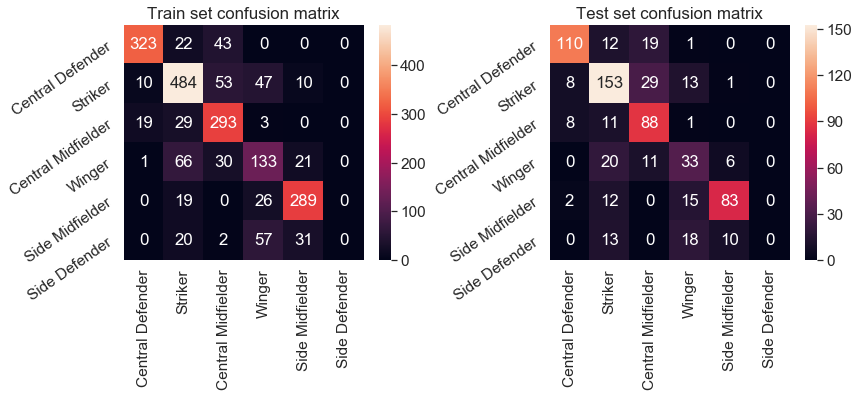

In [989]:
labels = set(data_classification['general_position'])
y_train_pred = gs_tree.predict(X_train)
y_test_pred = gs_tree.predict(X_test)
conf_matrix_plot(y_train,y_test,y_train_pred,y_test_pred ,labels)

W wierszach znajdują się rzeczywiste wartości, a w kolumnach przewidywane. Zarówno dla zbioru treningowego i testowego wyniki są obiecujące, a wzory co do popełnianych pomyłek zdają się powtarzać. Najwięcej źle sklasyfikowanych graczy to podobnie jak w poprzednim przypadku boczni obrońcy, których w żadnym przypadku nie zaklasyfikował poprawnie algorytm. Również i w przypadku drzewa decyzyjnego środkowi obrońcy są myleni głównie z napastnikami i środkowymi pomocnikami.

In [920]:
train_test_res(gs_tree, X_train, y_train, X_test,y_test)

,Train score,Test score
Results,0.749385,0.689808


Różnica pomiędzy wynikami na danych treningowych i testowych nie jest duża, co pewnie udało się osiągnąć dzięki odpowiedniemu dostrojeniu parametru "max_depth". Chociaż wyniki są słabsze niż przy modelu KNN to jednak nie są tragiczne.

<h3>4.3 Random Forest</h3>

Ostatnim z użytych algorytmów jest Random Forest. Tym razem również została wykorzystana została funkcja "make_pipeline" za pomocą której został utworzony estymator, który najpierw standaryzuje dane, a następnie wprowadza je do klasyfikatora RandomForestClassifier. Parametry, które zostały poddane dostrajaniu to:

* <b>bootstrap</b> - czy używać bootstrapowo wybranych próbek przy tworzeniu drzew, a nie całego zbioru (True lub False),

* <b>max_features</b> - liczba zmiennych, które należy wziąć pod uwagę przy poszukiwaniu najlepszego podziału (auto lub sqrt),

* <b>max_depth</b> - maksymalna głębokość drzewa (4 lub 5),

* <b>min_samples_split</b> - minimalna liczba próbek wymagana do podziału wewnętrznego węzła (2, 5 lub 10),

* <b>min_samples_leaf</b> - minimalna liczba próbek, które muszą znajdować się w węźle liściowym (1, 2 lub 4),

* <b>n_estimators</b> - liczba drzew, których wynik będzie uśredniany (200, 300, 400 lub 500).

Ponadto warto zwrócić uwagę na parametr dotyczący maksymalnej głębokości drzewa, którego wartość domyślnie w bibliotece sklearn jest ustawiona na "None" (oznacza to, że może ona być dowolna). W przypadku zbyt dużej głębokości algorytm wykazuje tendencję do przetrenowania, a więc osiąga dużą skuteczność na zbiorze, na którym się uczył, ale w przypadku zetknięcia z nowymi danymi osiąga słaby wynik. Poniżej zaprezentowany został wykres przedstawiający skuteczność modelu na zbiorze treningowym i testowym w zależności od ustawionej maksymalnej głębokości.

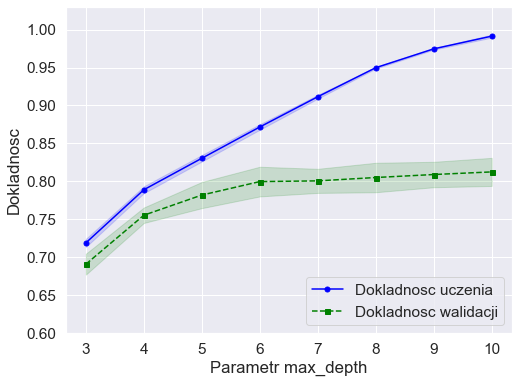

In [1032]:
pipe_random_repair = make_pipeline(StandardScaler(),
            RandomForestClassifier(max_features = 'sqrt',
                                   bootstrap = True,
                                   min_samples_leaf = 1,
                                   min_samples_split = 2,
                                   n_estimators = 400,
                                   random_state = 1))

from sklearn.model_selection import validation_curve

param_range = [3,4,5,6,7,8,9,10]
train_scores, test_scores =validation_curve(estimator = pipe_random_repair,
                                                         X = X_train,
                                                         y = y_train,
                                                         param_name = 'randomforestclassifier__max_depth',
                                                         cv = 5,
                                                         param_range = param_range)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores,axis =1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores,axis =1)

fig = plt.figure(figsize = (8,6))
plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'Dokladnosc uczenia')
plt.fill_between(param_range,train_mean + train_std, train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--', marker = 's',
         markersize = 5, label = 'Dokladnosc walidacji')
plt.fill_between(param_range,test_mean + test_std, test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.xlabel('Parametr max_depth')
plt.ylabel('Dokladnosc')
plt.legend(loc = 'lower right')
plt.ylim([0.6,1.03])
plt.show()

Podobnie jak w przypadku klasyfikatora drzewa decyzyjnego przy głębokości ustawionej na 5 krzywa uczenia i walidacji rozchodzą się wskazując na to, że model jest przetrenowany. W związku z czym w poniżej przeprowadzonym dostrajaniu parametrów wykorzystano przedział od 4 do 5 dla parametru "max_depth".

In [ ]:
#Combining standardisation with the model
pipe_random = make_pipeline(StandardScaler(),
                        RandomForestClassifier(random_state = 1))
#List Hyperparameters that we want to tune.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 4)]
max_features = ['auto', 'sqrt']
max_depth = [4,5]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

#Convert to dictionary
params_random = {"randomforestclassifier__n_estimators":n_estimators, "randomforestclassifier__max_features":max_features,
              "randomforestclassifier__max_depth":max_depth, "randomforestclassifier__min_samples_split": min_samples_split,
              "randomforestclassifier__min_samples_leaf": min_samples_leaf,"randomforestclassifier__bootstrap": bootstrap}

#Grid search
gs_random = GridSearchCV(estimator = pipe_random, param_grid = params_random, scoring = 'accuracy', cv = 10,return_train_score = True)

gs_random = gs_random.fit(X_train, y_train)

In [986]:
cv_res_frame(gs_random,index = "Random Forest CV results")

,Best mean score,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
Random Forest CV results,0.789266,True,5,auto,1,5,400


Dobrane parametry to: bootrapowe próbki przy tworzeniu drzew = True, maksymalna głębokość = t, maksymalna liczba zmiennych = auto, minimalna liczba próbek do podziału = 5, minimalna liczba próbek, które znajdować muszą się w węźle liściowym = 1 i liczba drzew = 400. Ponadto średni wynik dokładności dla tych parametrów wynosi 79% co jest lepszym wynikiem niż w przypadku drzewa decyzyjnego, ale słabszym od KNN.

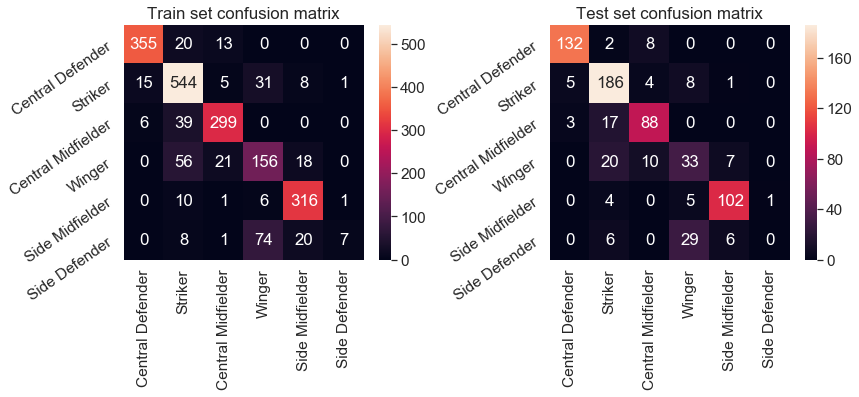

In [993]:
labels = set(data_classification['general_position'])
y_train_pred = gs_random.predict(X_train)
y_test_pred = gs_random.predict(X_test)
conf_matrix_plot(y_train,y_test,y_train_pred,y_test_pred ,labels)

W wierszach znajdują się rzeczywiste wartości, a w kolumnach przewidywane. Podobnie jak w poprzednich przypadkach dla zbioru treningowego i testowego wyniki są obiecujące, a wzory co do popełnianych pomyłek zdają się powtarzać. Najwięcej źle sklasyfikowanych graczy to podobnie jak w przypadku drzewa decyzyjnego boczni obrońcy, którzy głównie są myleni ze skrzydłowymi, może to mieć związek z tym, że jako bocznych obrońców sklasyifkowano cofniętych bocznych skrzydłowych. Tym razem również środkowi obrońcy są myleni głównie z napastnikami i środkowymi pomocnikami.

In [1029]:
train_test_res(gs_random, X_train, y_train, X_test,y_test)

,Train score,Test score
Results,0.825702,0.810931


Również tym razem udało się uninąć przetrenowania modelu, a różnica pomiędzy wynikami na danych treningowych i testowych nie jest duża. Wyniki są lepsze niż uzyskane za pomocą drzewa decyzyjnego, ale nieznacznie słabsze niż te, które udało się uzyskać KNN.

<h2>5. Podsumowanie</h2>

W badaniu zostały przeanalizane płace piłkarzy w zależności od pozycji na jakiej występują oraz ligi, w której gra ich klub. Ponadto zweryfikowano determinanty zarobków z podziałem na ligi, gdzie okazało się, że:

* <b>Premier League</b> - determinaty to: wartość piłkarza (0,0028), wiek (3243), potencjał (1047), umiejętność wykonywania sztuczek (3130), czy jest skrzydłowym (4681),

* <b>Bundesliga</b> - determinaty to: wartość piłkarza (0,0025), umiejętności obrony (176), umiejętność wykonywania wolei (247), czy jest skrzydłowym (5381),

* <b>Primera Division</b> - determinaty to: wartość piłkarza (0,0041), wiek (888), czy jest skrzydłowym (18270),

* <b>Serie A</b> - determinaty to: wartość piłkarza (0,0026), wiek (2065), potencjał (549), szybkość (115),

* <b>Ligue 1</b> - determinaty to: wartość piłkarza (0,0021), ocena ogólna (933), umiejętność zachowania zimnej krwi przy wykonywaniu karnych (84),  czy jest bocznym pomocnikiem (-4483), czy jest skrzydłowym (1712).

Wartości podane w nawiasach informują o ile euro zwiększą się zarobki przy zwiększeniu zmiennej o jedną jednostkę. We wszystkich ligach wartość piłkarza istotnie wpływa na zarobki, a to czy piłkarz jest skrzydłowym wyłącznie w Serie A nie jest istotne. Ostatnio można było zaobserwować w świecie piłki znaczny wzrost wartości transferów młodych utalentowanych piłkarzy. Chociaż ich wartość jest duża to jednak kluby często nie decydują się na zaburzenia w systemie płacowym, co może mieć odzwierciedlenie w tym, że wiek istotnie pozytywnie wpływa na zarobki piłkarzy.

W drugiej części zostały utworzone modele klasyfikacyjne (KNN, Drzewo Decyzyjne, Random Forest), za pomocą których przypisywano piłkarzy do pozycji (środkowy obrońća, boczny obrońca, środkowy pomocnik, boczny pomocnik, napastnik, skrzydłowy). Podsumowanie wyników zostało zaprezentowane na wykresie słupkowym poniżej.

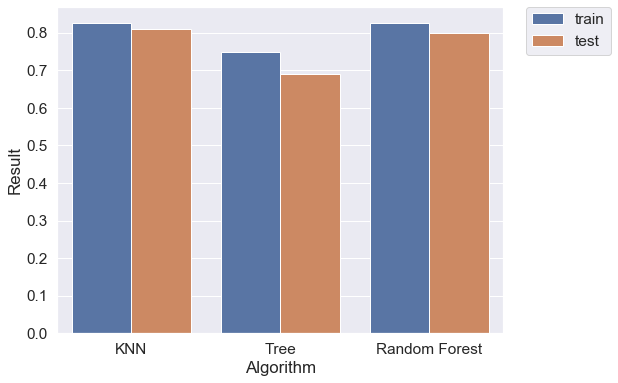

In [1004]:
fig = plt.figure(figsize = (8,6))
results = pd.DataFrame({"Result":[0.827179,0.810931, 0.749385,0.689808, 0.825702,0.799114],"Algorithm": ["KNN","KNN", "Tree", "Tree", "Random Forest", "Random Forest"],
                         "Dataset": ["train","test","train","test","train","test"]})

sns.barplot(x="Algorithm", y="Result", hue="Dataset", data=results)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Wszystkie modele osiągnęły satysfakcjonujące wyniki. Najlepszy okazał się algorytm K najbliższych sąsiadów, a tylko nieznacznie słabsze wyniki osiągnał Random Forest